<h1><b>Magic Gamma Telescope Dataset</b></h1>
<p>In this notebook, we are going to determine which model can predict whether a signal is a gamma signal or a background signal.</p>


In [1]:
#Data manipulation 
import numpy as np
import pandas as pd 

#Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

#Statistics
from scipy import stats
from scipy.stats import norm 

#Machine Learning
from sklearn.model_selection import cross_val_score


import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data_csv = pd.read_csv("magic04.csv")

df = raw_data_csv.copy()

In [3]:
df.head(5)

,length,width,size,conc,conc1,asym,m3long,m3trans,alpha,dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   length   19020 non-null  float64
 1   width    19020 non-null  float64
 2   size     19020 non-null  float64
 3   conc     19020 non-null  float64
 4   conc1    19020 non-null  float64
 5   asym     19020 non-null  float64
 6   m3long   19020 non-null  float64
 7   m3trans  19020 non-null  float64
 8   alpha    19020 non-null  float64
 9   dist     19020 non-null  float64
 10  class    19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


In [5]:
#The values of each feature are of different scales. We will have to standardize these before feeding the data into our model.

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
length,19020.0,53.250154,42.364855,4.2835,24.336000,37.14770,70.122175,334.1770
width,19020.0,22.180966,18.346056,0.0000,11.863800,17.13990,24.739475,256.3820
size,19020.0,2.825017,0.472599,1.9413,2.477100,2.73960,3.101600,5.3233
conc,19020.0,0.380327,0.182813,0.0131,0.235800,0.35415,0.503700,0.8930
conc1,19020.0,0.214657,0.110511,0.0003,0.128475,0.19650,0.285225,0.6752
asym,19020.0,-4.331745,59.206062,-457.9161,-20.586550,4.01305,24.063700,575.2407
m3long,19020.0,10.545545,51.000118,-331.7800,-12.842775,15.31410,35.837800,238.3210
m3trans,19020.0,0.249726,20.827439,-205.8947,-10.849375,0.66620,10.946425,179.8510
alpha,19020.0,27.645707,26.103621,0.0000,5.547925,17.67950,45.883550,90.0000
dist,19020.0,193.818026,74.731787,1.2826,142.492250,191.85145,240.563825,495.5610


In [6]:
#Replacing 'g' with 1 and '1' with 0
#We can also see that our dataset is imbalanced. This will affect our classification model. For now we will the dataset as it is.

df['class'] = df['class'].map({'g': 1,'h': 0})

df['class'].value_counts()

1    12332
0     6688
Name: class, dtype: int64

In [7]:
#Correlation of different features with class

corrmap = df.corr()

corrmap['class']

#Features that show strong correlation with class are length and width

length    -0.307572
width     -0.265596
size      -0.117795
conc       0.024615
conc1      0.004797
asym       0.173587
m3long     0.193409
m3trans   -0.003837
alpha     -0.460979
dist      -0.065203
class      1.000000
Name: class, dtype: float64

<AxesSubplot:>

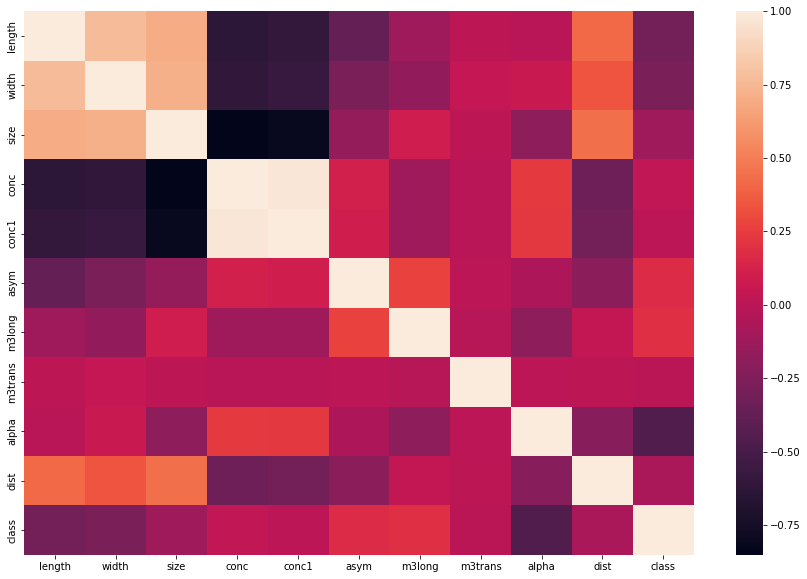

In [8]:
#It seems that some features are highly correlated with one another. It will cause a problem if we are doing linear regression, but since this is a classification problem, multicollinearity will not be an issue. 

plt.figure(figsize=(15,10))
sns.heatmap(corrmap)

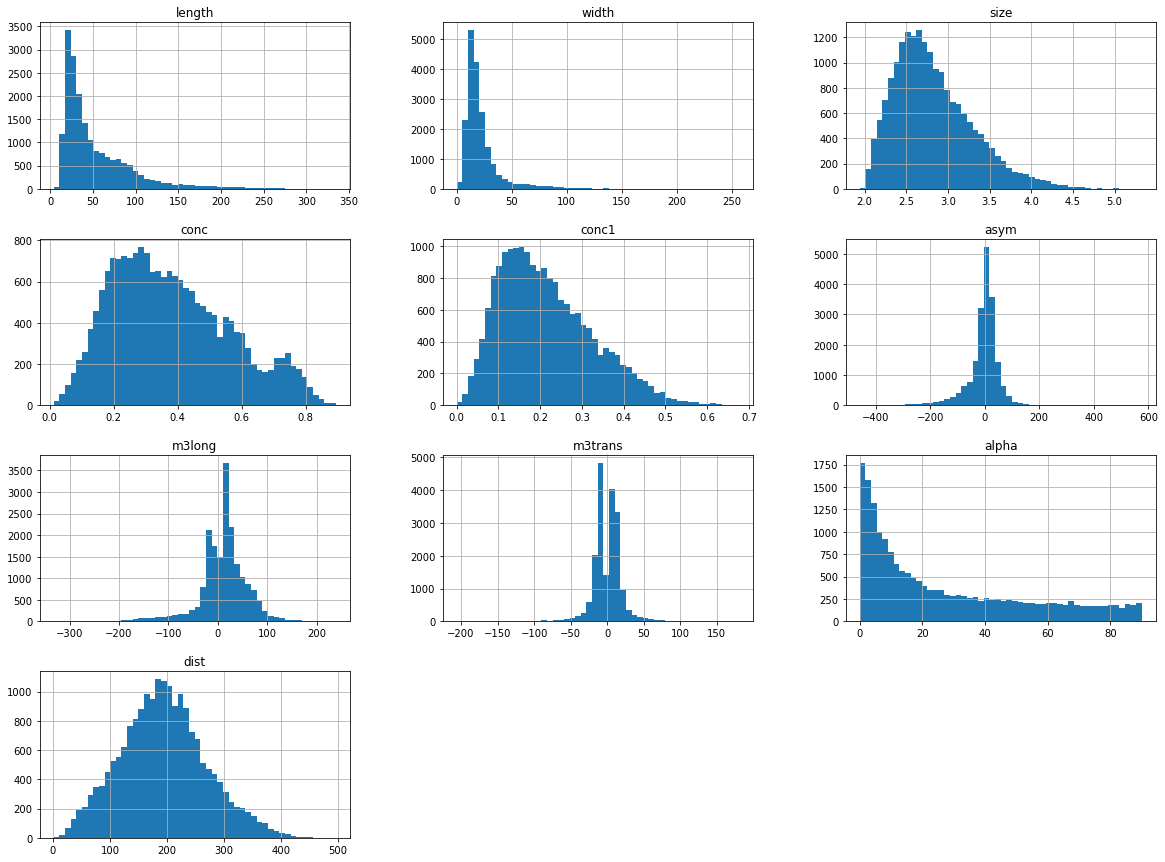

In [9]:
#We can also check the distribution of the values within our features


df.drop('class', axis=1).hist(bins=50,figsize=(20,15));

In [10]:
#Now we need to separate our dataset into a training set and a test set. From this point, we will only look at the training set.

from sklearn.model_selection import train_test_split

X = df.drop('class', axis=1)
y = df['class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
#We mentioned earlier that we will have to scale the values of our features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit_transform(X_train)

scaler.transform(X_test) #We do not fit the test set to avoid data leakage


array([[-0.12706339, -0.60654378,  0.27473973, ..., -0.11849846,
        -0.02749297, -0.38867022],
       [-0.705253  , -1.20932657, -1.24138369, ..., -0.00845755,
        -0.31705749,  0.54834957],
       [-0.30388402, -0.15410598,  1.07969186, ..., -0.34942023,
        -0.67101758,  0.01729864],
       ...,
       [-0.23992231, -0.47022141, -0.6132211 , ..., -0.68312278,
        -0.16983326,  0.05433015],
       [-0.60217352,  0.05546138, -0.06954575, ...,  0.73263999,
         2.282426  , -0.17289027],
       [-0.57513887, -0.08197018,  0.26417883, ..., -0.86185013,
         0.15817324, -0.53671074]])

<h2>Metrics without balancing the dataset</h2>
<p>We will use our imbalanced dataset to choose the best classifier for our model</p>

In [12]:
#Machine learning
#We won't use GridSearchCV on SVC because of slow performance

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score #determine the performance of models
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score #used to compare performance of models


In [13]:
#We define a function that would fit and train the data to our model

xgbc = XGBClassifier()
forest = RandomForestClassifier()
knn= KNeighborsClassifier()
log = LogisticRegression()

def get_metrics(model):
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    train_preds = model.predict(X_train)
    
    print('Train Performance')
    print('\n')
    print(confusion_matrix(y_train,train_preds))
    print('\n')
    print(classification_report(y_train,train_preds))
    print('\n')
    print('-----------------------------------------------------------')
    print('Test Performance')
    print('\n')
    print(confusion_matrix(y_test,preds))
    print('\n')
    print(classification_report(y_test,preds))
    print('\n')
    print('Accuracy score is: {:.2f} %'.format(accuracy_score(y_test,preds)*100))
    


In [14]:
#Confusion matrix, and classification report of logistic regression model for both training and test set.
#Model is not overfitting.
#Accuracy score is 77.16%

get_metrics(log)

Train Performance


[[2645 1837]
 [ 831 7430]]


              precision    recall  f1-score   support

           0       0.76      0.59      0.66      4482
           1       0.80      0.90      0.85      8261

    accuracy                           0.79     12743
   macro avg       0.78      0.74      0.76     12743
weighted avg       0.79      0.79      0.78     12743



-----------------------------------------------------------
Test Performance


[[1289  917]
 [ 410 3661]]


              precision    recall  f1-score   support

           0       0.76      0.58      0.66      2206
           1       0.80      0.90      0.85      4071

    accuracy                           0.79      6277
   macro avg       0.78      0.74      0.75      6277
weighted avg       0.79      0.79      0.78      6277



Accuracy score is: 78.86 %


In [15]:
#Confusion matrix, and classification report of XGBClassifier model for both training and test set.
#Model is not overfitting.
#Accuracy score is 90.32%

get_metrics(xgbc)

[23:32:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train Performance


[[4173  309]
 [  54 8207]]


              precision    recall  f1-score   support

           0       0.99      0.93      0.96      4482
           1       0.96      0.99      0.98      8261

    accuracy                           0.97     12743
   macro avg       0.98      0.96      0.97     12743
weighted avg       0.97      0.97      0.97     12743



-----------------------------------------------------------
Test Performance


[[1705  501]
 [ 236 3835]]


              precision    recall  f1-score   support

           0       0.88      0.77      0.82      2206
           1       0.88      0.94      0.91      4071

    accuracy                           0

In [16]:
#Confusion matrix, and classification report of random forest classifier model for both training and test set.
#Model looks like it's overfitting. But for random forests, a 100% accuracy score on the training set, doesn't usually mean that the model is overfitting.
#Accuracy score is 92.94%

get_metrics(forest)

Train Performance


[[4482    0]
 [   0 8261]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4482
           1       1.00      1.00      1.00      8261

    accuracy                           1.00     12743
   macro avg       1.00      1.00      1.00     12743
weighted avg       1.00      1.00      1.00     12743



-----------------------------------------------------------
Test Performance


[[1678  528]
 [ 248 3823]]


              precision    recall  f1-score   support

           0       0.87      0.76      0.81      2206
           1       0.88      0.94      0.91      4071

    accuracy                           0.88      6277
   macro avg       0.87      0.85      0.86      6277
weighted avg       0.88      0.88      0.87      6277



Accuracy score is: 87.64 %


In [17]:
#Confusion matrix, and classification report of KNN model for both training and test set.

get_metrics(knn)

Train Performance


[[3059 1423]
 [ 398 7863]]


              precision    recall  f1-score   support

           0       0.88      0.68      0.77      4482
           1       0.85      0.95      0.90      8261

    accuracy                           0.86     12743
   macro avg       0.87      0.82      0.83     12743
weighted avg       0.86      0.86      0.85     12743



-----------------------------------------------------------
Test Performance


[[1295  911]
 [ 298 3773]]


              precision    recall  f1-score   support

           0       0.81      0.59      0.68      2206
           1       0.81      0.93      0.86      4071

    accuracy                           0.81      6277
   macro avg       0.81      0.76      0.77      6277
weighted avg       0.81      0.81      0.80      6277



Accuracy score is: 80.74 %


Text(0, 0.5, 'Accuracy Scores')

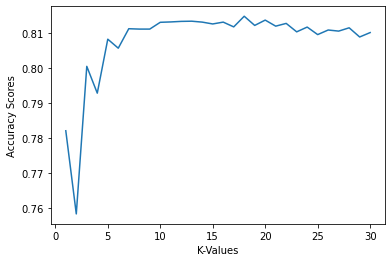

In [18]:
#When using KNN, we must specify the n_neighbors (K-value). We will try to find the optimal K-value first
#For KNN, a higher K-value means a simpler model. We need to find the highest K-value that would maximize our accuracy score.  
#It seems like the best value is at around 7.

k_range = range(1,31)
k_scores = []

for i in  k_range:
    knn = KNeighborsClassifier(n_neighbors=i)
    score = cross_val_score(knn,X,y,cv=10,scoring='accuracy')
    k_scores.append(score.mean())
    
plt.plot(k_range,k_scores)
plt.xlabel('K-Values')
plt.ylabel('Accuracy Scores')

In [19]:
#If we set the k-value to 7, we improve the accuracy by approx. 2 pts

knn = KNeighborsClassifier(n_neighbors=7)

get_metrics(knn)

Train Performance


[[2896 1586]
 [ 394 7867]]


              precision    recall  f1-score   support

           0       0.88      0.65      0.75      4482
           1       0.83      0.95      0.89      8261

    accuracy                           0.84     12743
   macro avg       0.86      0.80      0.82     12743
weighted avg       0.85      0.84      0.84     12743



-----------------------------------------------------------
Test Performance


[[1277  929]
 [ 284 3787]]


              precision    recall  f1-score   support

           0       0.82      0.58      0.68      2206
           1       0.80      0.93      0.86      4071

    accuracy                           0.81      6277
   macro avg       0.81      0.75      0.77      6277
weighted avg       0.81      0.81      0.80      6277



Accuracy score is: 80.68 %


<h2>Results</h2>
<ul>
    <li>Logistic regression produced an accuracy score of 78.86% with avg recall of 74%</li>
    <li>XGBClassifier produced an accuracy score of 88.26% with avg recall of 86%</li>
    <li>Random Forest Classifier produced an accuracy score of 87.80% with avg recall of 85%</li>
    <li>KNN at k=7 produced an accuracy score of 80.68% with avg recall of 75%</li>
    <li>Recall scores of the models reflect the imbalance in the dataset</li>
</ul>

<h2>Why do we need to balance the dataset?</h2>
<ul><li>The reason is because the model will perform poorly when predicting the class of the minority sample</li></ul>

<h2>ROC Area Under the Curve - Unbalanced Dataset</h2>
<ul>
    <li>For accurately predicting the classes of the samples in unbalanced datasets, XGBClassifier works best </li>
    <li>However, there are instances where we want to know the preformance of a  model to predict the probability of each sample belonging to a class. This is where ROC AUC comes in</li>
    <li>Without diving into the details, a model with ROC AUC value close to 1 is good at predicting the probability that a sample belongs to a certain class </li>
    
</ul>

In [20]:
#XGBClassifier
xgbc.fit(X_train,y_train)
xgbc_probs = xgbc.predict_proba(X_test)
xgbc_probs = xgbc_probs[:,1]
xgbc_auc = roc_auc_score(y_test,xgbc_probs)

print('XGBClassifier  AUC: {:.3f}'.format(xgbc_auc))

[23:33:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier  AUC: 0.931


In [21]:
forest.fit(X_train,y_train)
forest_probs = forest.predict_proba(X_test)
forest_probs = forest_probs[:,1]
forest_auc = roc_auc_score(y_test,forest_probs)

print('Random Forest Classifier  AUC: {:.3f}'.format(forest_auc))

Random Forest Classifier  AUC: 0.931


In [22]:
knn.fit(X_train,y_train)
knn_probs = knn.predict_proba(X_test)
knn_probs = knn_probs[:,1]
knn_auc = roc_auc_score(y_test,knn_probs)

print('KNN Prediction AUC: {:.3f}'.format(knn_auc))

KNN Prediction AUC: 0.841


In [23]:
log.fit(X_train,y_train)
log_probs = log.predict_proba(X_test)
log_probs = log_probs[:,1]
log_auc = roc_auc_score(y_test,log_probs)

print('Logistic Regression  AUC: {:.3f}'.format(log_auc))

Logistic Regression  AUC: 0.837


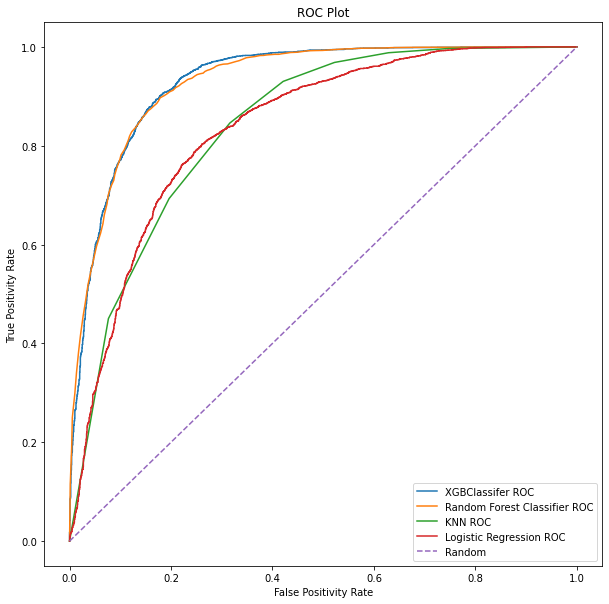

In [24]:
#We plot the ROC of the models
#We can see that the 

r_probs = [0 for _ in range(len(y_test))] #This is just for the random prediction
r_auc = roc_auc_score(y_test,r_probs)
r_fpr,r_tpr,_ = roc_curve(y_test,r_probs)

forest_fpr,forest_tpr,_ = roc_curve(y_test,forest_probs)
xgbc_fpr, xgbc_tpr,_ = roc_curve(y_test,xgbc_probs)
log_fpr, log_tpr,_ = roc_curve(y_test,log_probs)
knn_fpr, knn_tpr,_ = roc_curve(y_test,knn_probs)

plt.figure(figsize=(10,10))

plt.plot(xgbc_fpr,xgbc_tpr,label='XGBClassifer ROC')
plt.plot(forest_fpr,forest_tpr,label='Random Forest Classifier ROC')
plt.plot(knn_fpr,knn_tpr,label='KNN ROC')
plt.plot(log_fpr,log_tpr,label='Logistic Regression ROC')
plt.plot(r_fpr,r_tpr,linestyle='--',label='Random')

plt.title('ROC Plot')
plt.xlabel('False Positivity Rate')
plt.ylabel('True Positivity Rate')
plt.legend()

<h2>Results</h2>
<ul>
    <li>XGBClassifier has the highest AUC value at 0.931</li>
</ul>

<h2>Metrics with balanced dataset and cross-validation</h2>
<ul>
    <li>The reason is because the model will perform poorly when predicting the class of the minority sample</li>
    <li>We will use an oversampling method called SMOTE</li>
    <li>Train test split randomly shuffles the samples; thus the classifiers will produce different metrics for each shuffle. Cross-validation remedies this</li>
    
    
</ul>


In [25]:
from imblearn.over_sampling import SMOTE

over = SMOTE()

X, y = over.fit_resample(X,y)




In [26]:
scores_forest = cross_val_score(forest,X,y, cv=10, scoring='accuracy')
print('Average accuracy score for random forest is: {:.2f} %'.format(scores_forest.mean()*100))
print('\n')
print('Standard deviation is: {:.2f} %'.format(scores_forest.std()*100))

Average accuracy score for random forest is: 89.35 %


Standard deviation is: 1.30 %


In [27]:
scores_knn = cross_val_score(KNeighborsClassifier(n_neighbors=7),X,y, cv=10, scoring='accuracy')
print('Average accuracy score for KNN is: {:.2f} %'.format(scores_knn.mean()*100))
print('\n')
print('Standard deviation is: {:.2f} %'.format(scores_knn.std()*100))

Average accuracy score for KNN is: 82.55 %


Standard deviation is: 2.29 %


In [28]:
scores_log = cross_val_score(log,X,y, cv=10, scoring='accuracy')
print('Average accuracy score for logistic regression is: {:.2f} %'.format(scores_log.mean()*100))
print('\n')
print('Standard deviation is: {:.2f} %'.format(scores_log.std()*100))

Average accuracy score for logistic regression is: 76.31 %


Standard deviation is: 0.40 %


In [29]:
scores_xgbc = cross_val_score(XGBClassifier(use_label_encoder=False), X,y, cv=10, scoring='accuracy') 
print('Average accuracy score for XGBClassifier is: {:.2f} %'.format(scores_xgbc.mean()*100))
print('\n')
print('standard deviation is: {:.2f} %'.format(scores_xgbc.std()*100))

[23:34:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:34:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:34:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:34:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

<h2>Results from balanced dataset</h2>

<ul>
    <li>Logistic regression produced an avg accuracy score of 76.59% </li>
    <li>XGBClassifier produced an avg accuracy score of 88.55% </li>
    <li>Random Forest Classifier produced an accuracy score of 89.21% </li>
    <li>KNN at k=7 produced an accuracy score of 82.94% </li>
    <li>The accuracy score of each classifier increased, except for logistic regression</li>
    <li>Unlike in the imbalanced dataset, random forest classifier performed better when using balanced dataset. This is because XGBClassifier can work with imbalanced datasets while random forest classifier does not</li>
</ul>

<h2>ROC Area Under the Curve - Balanced Dataset</h2>
<ul>
    <li>We are now going to compare the average ROC AUC value for each classifier</li>
 

In [30]:
xgbc_auc = cross_val_score(XGBClassifier(use_label_encoder=False),X,y,cv=10,scoring='roc_auc')
print('Average AUC value for XGBClassifier is: {:.3f} '.format(xgbc_auc.mean()))
print('\n')
print('Standard deviation is: {:.2f} %'.format(xgbc_auc.std()))

[23:34:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:34:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:34:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:34:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [31]:
rf_auc = cross_val_score(RandomForestClassifier(),X,y,cv=10,scoring='roc_auc')
print('Average AUC value for RF Classifier is: {:.3f} '.format(rf_auc.mean()))
print('\n')
print('Standard deviation is: {:.2f} %'.format(rf_auc.std()))

Average AUC value for RF Classifier is: 0.959 


Standard deviation is: 0.01 %


In [32]:
knn_auc = cross_val_score(KNeighborsClassifier(n_neighbors=7),X,y,cv=10,scoring='roc_auc')
print('Average AUC value for KNN is: {:.3f} '.format(knn_auc.mean()))
print('\n')
print('Standard deviation is: {:.2f} %'.format(knn_auc.std()))

Average AUC value for KNN is: 0.909 


Standard deviation is: 0.02 %


In [33]:
log_auc = cross_val_score(LogisticRegression(),X,y,cv=10,scoring='roc_auc')
print('Average AUC value for logistic regression is: {:.3f} '.format(log_auc.mean()))
print('\n')
print('Standard deviation is: {:.2f} %'.format(log_auc.std()))

Average AUC value for logistic regression is: 0.837 


Standard deviation is: 0.01 %


<h2>Results of Avg AUC from Balanced Dataset</h2>

<ul>
    <li>Logistic regression produced an avg AUC value of 0.840 </li>
    <li>XGBClassifier produced an avg AUC value of 0.952 </li>
    <li>Random Forest Classifier produced an avg AUC of 0.958  </li>
    <li>KNN at k=7 produced an avg AUC value of 0.910</li>
    <li>In predicting the probability of classes, RF Classifier works best</li>
    
</ul>

<h2>Conclusion</h2>
<p>RF Classifier outperformed all classifiers in terms of avg accuracy score and avg AUC score. However, in terms of computing speed, XGBClassifier is considerably faster.</p>

<h2>Recommendations</h2>
<ul>
    <li>Create an ANN</li>
    <li>Perform hyperparameter tuning to XGBClassifer and RF Classifier and compare performance</li>
</ul>